# PV Installations and Electricity Price Analysis in Switzerland

## Table of Contents
1. [Introduction](#Introduction)
2. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
3. [Simulations](#Simulation)
4. [Groupe E Tariff Simulations](#Groupe-E)
5. [Predictions](#Prediction)
6. [OFEN Data Analysis](#OFEN)
7. [Conclusion](#Conclusion)

## Introduction
<a id="Introduction"></a>
The growing adoption of PV installations in Switzerland presents both opportunities and challenges for energy stakeholders. This report explores historical data on PV installations and electricity prices, uncovering patterns and trends that form the foundation for further analysis. Using this data, we simulate and evaluate the potential profitability of leveraging an energy storage system. 

## Exploratory Data Analysis
<a id="Exploratory-Data-Analysis"></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

In [3]:
# Loading data
pv_data = pd.read_excel("new_PVs.xlsx")
price_data = pd.read_csv("prices.csv")
production_data = pd.read_excel("PV_production.xlsx")

Source: 
* https://www.energy-charts.info/?l=en&c=CH
* https://pubdb.bfe.admin.ch/de/suche?keywords=395

In [4]:
# Checking for missing data
missing_pv = pv_data.isnull().sum()
print(missing_pv)

missing_price = price_data.isnull().sum()
print(missing_price)

missing_production = production_data.isnull().sum()
print(missing_production)

Year                         0
New_PVs_MWp                  0
Installed Capacity Growth    1
dtype: int64
Date (GMT+1)              0
Day Ahead Auction (CH)    0
dtype: int64
Year                        0
PV Production (GWh)         0
Annual Production Growth    1
dtype: int64


There is one missing value in Installed Capacity Growth and Annual Production Growth columns respectively as there is no growth rate in the first year. We will ignore them as these are not used in this analysis.

In [5]:
# Cleaning data
price_data['Date'] = pd.to_datetime(price_data['Date (GMT+1)'], format="%d.%m.%Y %H:%M")
price_data['Year'] = price_data['Date'].dt.year
price_data['Day Ahead Auction (CH)'] = pd.to_numeric(price_data['Day Ahead Auction (CH)'])

### Has the number of imbalances (negative prices) been increasing?
Yes, the number of imbalances has been increasing, with a sharp rise observed in 2024. However, the year 2022 does not seem to follow this upward trend. An explanation will be provided in a later section.

In [6]:
# Counting negative price occurrences per year
negative_price_count = price_data[price_data['Day Ahead Auction (CH)'] < 0].groupby('Year').size().reset_index(name='NP_Count')

In [7]:
print(negative_price_count)

   Year  NP_Count
0  2015         9
1  2016        24
2  2017         5
3  2018        29
4  2019        17
5  2020        75
6  2021        41
7  2022         1
8  2023        76
9  2024       292


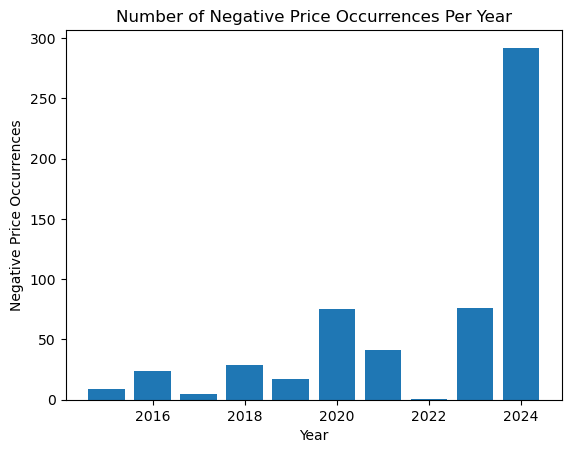

In [8]:
# Plotting the number of negative price occurences per year
plt.bar(negative_price_count['Year'], negative_price_count['NP_Count'])
plt.title('Number of Negative Price Occurrences Per Year')
plt.xlabel('Year')
plt.ylabel('Negative Price Occurrences')
plt.show()

### Is there any relationship between the cumulative PV production and negative price occurrences?

In [9]:
# Merging dataframes on 'Year'
production_price_count = production_data.merge(negative_price_count, on='Year', how='left')
print(production_price_count)

# Removing 2022 as it is considered as an outliner
#pv_price_count_without_2022 = pv_price_count[pv_price_count['Year'] != 2022]

    Year  PV Production (GWh)  Annual Production Growth  NP_Count
0   2035                28300                  1.080153       NaN
1   2034                26200                  1.087137       NaN
2   2033                24100                  1.095455       NaN
3   2032                22000                  1.111111       NaN
4   2031                19800                  1.125000       NaN
5   2030                17600                  1.142857       NaN
6   2029                15400                  1.157895       NaN
7   2028                13300                  1.156522       NaN
8   2027                11500                  1.161616       NaN
9   2026                 9900                  1.178571       NaN
10  2025                 8400                  1.217391       NaN
11  2024                 6900                  1.492215     292.0
12  2023                 4624                  1.198548      76.0
13  2022                 3858                  1.357495       1.0
14  2021  

In [10]:
# Calculating the correlation coefficient
correlation = production_price_count['PV Production (GWh)'].corr(production_price_count['NP_Count'])
print(f"Correlation coefficient: {correlation}")

Correlation coefficient: 0.8419431665766013


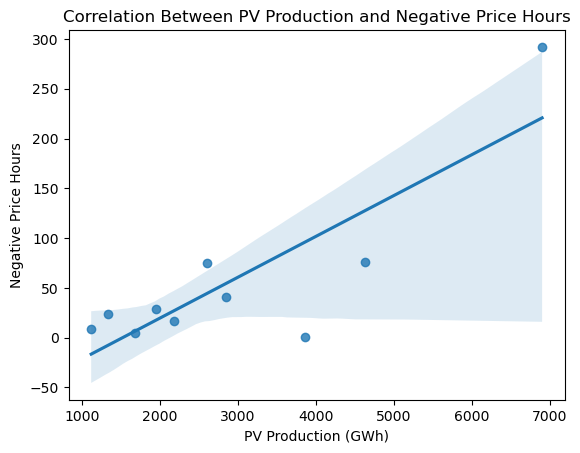

In [11]:
# Plotting with trend line
sns.regplot(x='PV Production (GWh)', y='NP_Count', data=production_price_count)
plt.title('Correlation Between PV Production and Negative Price Hours')
plt.xlabel('PV Production (GWh)')
plt.ylabel('Negative Price Hours')
plt.show()

### How will negative price hours evolve if the current trend continues?

In [12]:
production_price_df = production_price_count.copy()

df_train = production_price_df.dropna(subset=['NP_Count'])

X = df_train[['Year', 'PV Production (GWh)', 'Annual Production Growth']]
y = df_train['NP_Count']

model = LinearRegression()
model.fit(X, y)

df_future = production_price_df[production_price_df['Year'] >= 2025].copy()
X_future = df_future[['Year', 'PV Production (GWh)', 'Annual Production Growth']]
df_future['Predicted_Negative_Prices'] = model.predict(X_future)

print(df_future[['Year', 'Predicted_Negative_Prices']])

    Year  Predicted_Negative_Prices
0   2035                2489.105234
1   2034                2277.357877
2   2033                2065.230519
3   2032                1851.011585
4   2031                1625.220724
5   2030                1398.298924
6   2029                1172.180685
7   2028                 962.815117
8   2027                 787.833487
9   2026                 633.622978
10  2025                 485.256842


In [13]:
production_price_df = production_price_df[production_price_df['Year'] >= 2015]

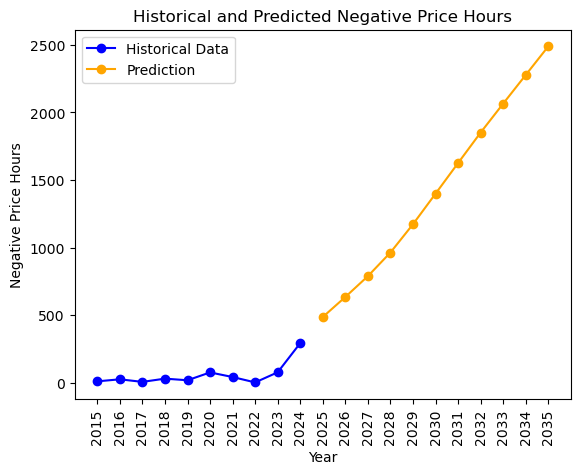

In [14]:
plt.plot(production_price_df[production_price_df['Year'] <= 2024]['Year'], production_price_df[production_price_df['Year'] <= 2024]['NP_Count'], label='Historical Data', color='b', marker='o')
plt.plot(df_future[df_future['Year'] >= 2025]['Year'], df_future[df_future['Year'] >= 2025]['Predicted_Negative_Prices'], label='Prediction', color='orange', marker='o')

plt.xticks(production_price_df['Year'].astype(int), rotation=90) 
plt.xlabel('Year')
plt.ylabel('Negative Price Hours')
plt.title('Historical and Predicted Negative Price Hours')
plt.legend()
plt.show()

In [15]:
production_price_df['NP_Count'].update(df_future['Predicted_Negative_Prices'])
production_price_df = production_price_df.reset_index()

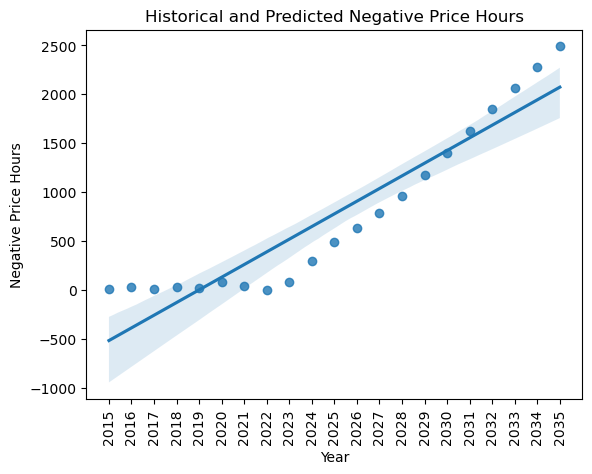

In [16]:
sns.regplot(x='Year', y='NP_Count', data=production_price_df)
plt.xticks(production_price_df['Year'].astype(int), rotation=90) 
plt.xlabel('Year')
plt.ylabel('Negative Price Hours')
plt.title('Historical and Predicted Negative Price Hours')
plt.show()

### Is there any relationship between the number of PV installations and negative price occurrences?¶
There is a strong positive relationship between these variables as the increased production of solar energy can lead to an oversupply in the market, resulting in negative prices.

In [17]:
# Joining dataframes
pv_price_count = pv_data.merge(negative_price_count, on='Year', how='inner')

In [18]:
print(pv_price_count)

   Year  New_PVs_MWp  Installed Capacity Growth  NP_Count
0  2024         1800                   1.060071       292
1  2023         1698                   1.507993        76
2  2022         1126                   1.597163         1
3  2021          705                   1.430020        41
4  2020          493                   1.484940        75
5  2019          332                   1.225092        17
6  2018          271                   1.124481        29
7  2017          241                   0.912879         5
8  2016          264                   0.783383        24
9  2015          337                   1.112211         9


In [19]:
# Calculating the correlation coefficient
correlation = pv_price_count['New_PVs_MWp'].corr(pv_price_count['NP_Count'])
print(f"Correlation coefficient: {correlation}")

Correlation coefficient: 0.705129427841221


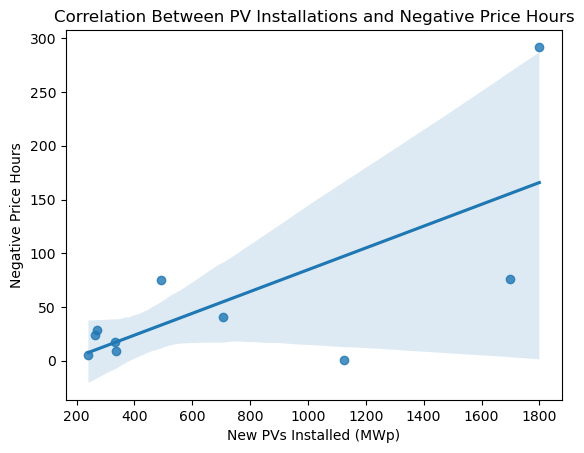

In [20]:
# Plotting with trend line
sns.regplot(x='New_PVs_MWp', y='NP_Count', data=pv_price_count)
plt.title('Correlation Between PV Installations and Negative Price Hours')
plt.xlabel('New PVs Installed (MWp)')
plt.ylabel('Negative Price Hours')
plt.show()

### How many days per year negative price occurrences happen?

In [21]:
# Extracting only the rows with negative prices
negative_price_data = price_data[price_data['Day Ahead Auction (CH)'] < 0].copy()
# Creating a 'Date_only' column containing just the date (no time)
negative_price_data['Date_only'] = negative_price_data['Date'].dt.date
# Grouping by day
negative_price_daily_count = negative_price_data.groupby('Date_only').size()
print(negative_price_daily_count)

Date_only
2015-05-10     5
2015-05-17     4
2016-03-28     4
2016-05-08     6
2016-05-15    12
              ..
2024-09-29     2
2024-10-06     2
2024-10-13     9
2024-10-20     3
2024-10-21     2
Length: 120, dtype: int64


In [22]:
# Extracting year from the 'Date_only' column
negative_price_data['Year'] = pd.to_datetime(negative_price_data['Date_only']).dt.year
# Counting unique days with negative prices per year
negative_price_days = negative_price_data.groupby('Year')['Date_only'].nunique().reset_index(name='Negative_Price_Days')
print(negative_price_days)

   Year  Negative_Price_Days
0  2015                    2
1  2016                    5
2  2017                    1
3  2018                    4
4  2019                    6
5  2020                   15
6  2021                    8
7  2022                    1
8  2023                   18
9  2024                   60


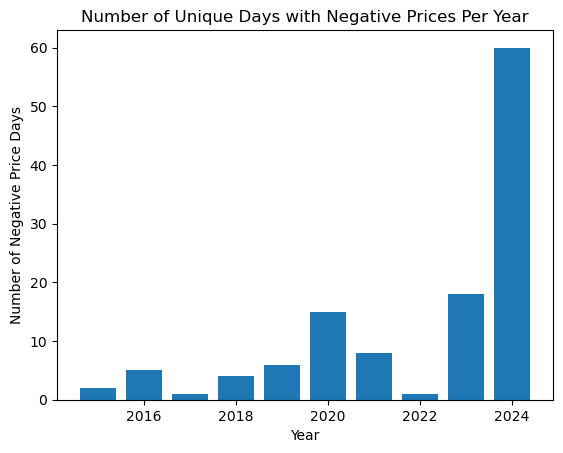

In [23]:
# Plotting
plt.bar(negative_price_days['Year'], negative_price_days['Negative_Price_Days'])
plt.title('Number of Unique Days with Negative Prices Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Negative Price Days')
plt.show()

In [24]:
# Joining dataframes
pv_price_days = pv_price_count.merge(negative_price_days, on='Year', how='inner')
# Removing 2022 as it is considered as an outliner
#pv_price_days_without_2022 = pv_price_days[pv_price_days['Year'] != 2022]

### Is the number of days with negative prices associated with PV installations?
Yes, the number of days with negative prices is positively associated with the number of PV installations, revealing a even stronger correlation coefficient of 0.82. 

In [25]:
# Calculating the correlation coefficient
correlation_pv_price_days = pv_price_days['New_PVs_MWp'].corr(pv_price_days['Negative_Price_Days'])
print(f"Correlation coefficient: {correlation_pv_price_days}")

Correlation coefficient: 0.7323675564209885


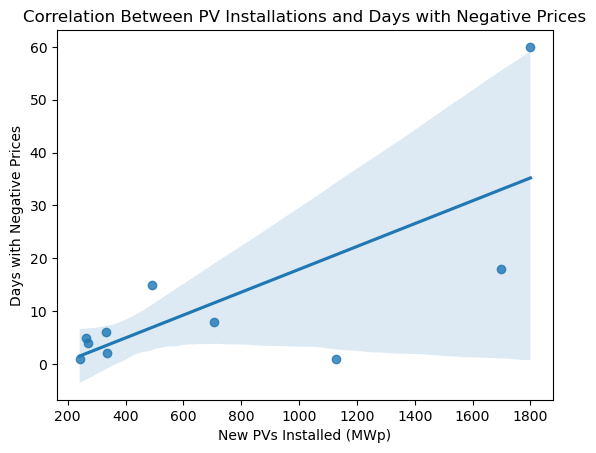

In [26]:
# Plotting with trend line
sns.regplot(x='New_PVs_MWp', y='Negative_Price_Days', data=pv_price_days)
plt.title('Correlation Between PV Installations and Days with Negative Prices')
plt.xlabel('New PVs Installed (MWp)')
plt.ylabel('Days with Negative Prices')
plt.show()

### When negative price occurrences happen?

In [27]:
# Adding a column to specify days of the week
negative_price_data['Day_of_Week'] = negative_price_data['Date'].dt.day_name()
# Adding a column for the hour
negative_price_data['Hour'] = negative_price_data['Date'].dt.hour

In [28]:
# Counting the number grouped by hour
negative_by_hour = negative_price_data.groupby('Hour').size().reset_index(name='NP Count')

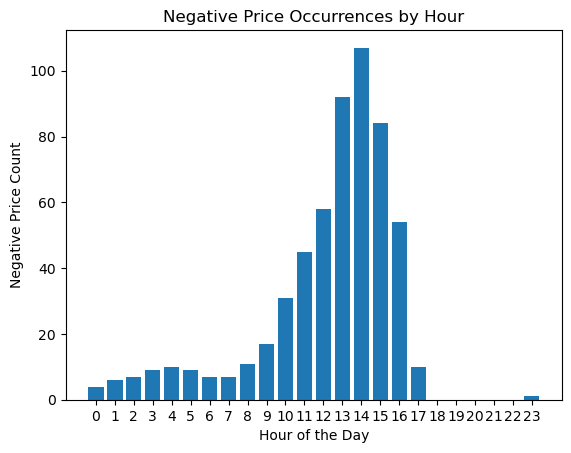

In [29]:
# Plotting the count by hour
plt.bar(negative_by_hour['Hour'], negative_by_hour['NP Count'])
plt.title('Negative Price Occurrences by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Negative Price Count')
plt.xticks(range(0, 24))
plt.show()

The plot above reveals that negative price occurrences often happen around 2pm.

In [30]:
# Counting the number grouped by day of the week
negative_by_day = negative_price_data.groupby('Day_of_Week').size().reset_index(name='NP Count')

# Defining the order of the days
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
negative_by_day['Day_of_Week'] = pd.Categorical(negative_by_day['Day_of_Week'], categories=day_order)
negative_by_day = negative_by_day.sort_values('Day_of_Week')

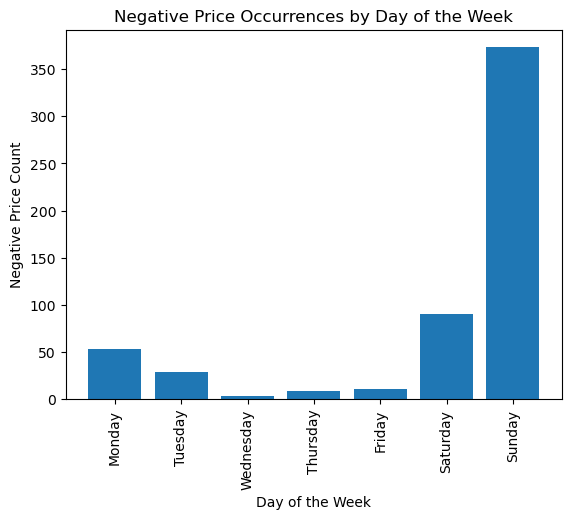

In [31]:
# Plotting grouped by day of the week
plt.bar(negative_by_day['Day_of_Week'], negative_by_day['NP Count'])
plt.title('Negative Price Occurrences by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Negative Price Count')
plt.xticks(rotation=90)
plt.show()

Negative price occurrences are more frequent over the weekends, with some also observed on Mondays.

### Which hour and day have the highest or lowest prices?

In [32]:
# Adding a column to specify days of the week
price_data['Day_of_Week'] = price_data['Date'].dt.day_name()
# Adding a column for the hour
price_data['Hour'] = price_data['Date'].dt.hour

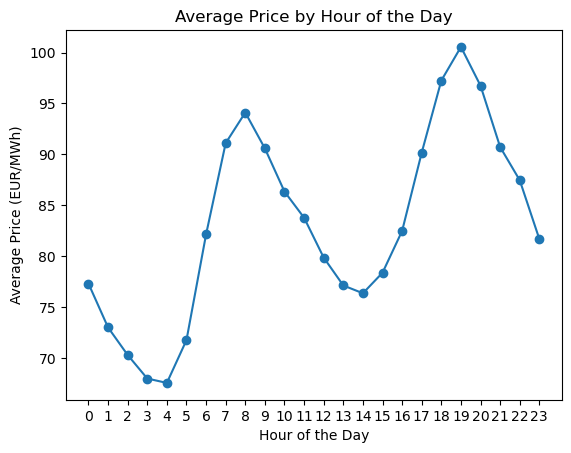

In [33]:
# Calculating average price grouped by hour
grouped_by_hour = price_data.groupby('Hour')['Day Ahead Auction (CH)'].mean().reset_index()

plt.plot(grouped_by_hour['Hour'], grouped_by_hour['Day Ahead Auction (CH)'], marker='o')
plt.title('Average Price by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Price (EUR/MWh)')
plt.xticks(range(0, 24))  
plt.show()

Two peaks in price patterns are observed: lower prices around 4 am and 2 pm, and higher prices around 8 am and 7 pm.

In [34]:
# Calculating average price grouped by day of the week
grouped_by_day = price_data.groupby('Day_of_Week')['Day Ahead Auction (CH)'].mean().reset_index()
grouped_by_day['Day_of_Week'] = pd.Categorical(grouped_by_day['Day_of_Week'], categories=day_order)
grouped_by_day = grouped_by_day.sort_values('Day_of_Week')

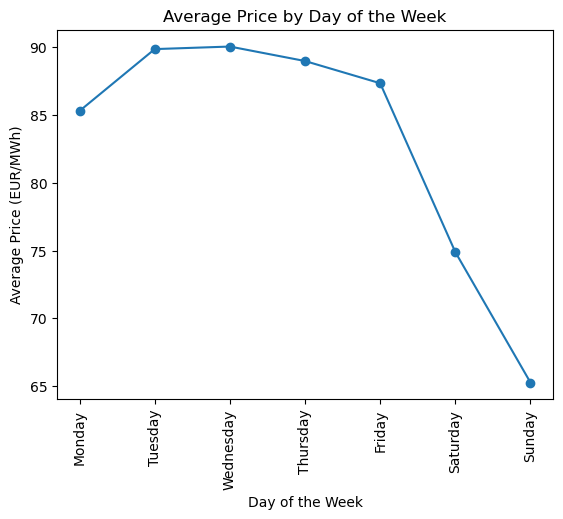

In [35]:
# Plotting
plt.plot(grouped_by_day['Day_of_Week'], grouped_by_day['Day Ahead Auction (CH)'], marker='o')
plt.title('Average Price by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Price (EUR/MWh)')
plt.xticks(rotation=90)
plt.show()

In [36]:
# Grouping by hour and day of the week to get the average price for each hour of each day
grouped_by_day_hour = price_data.groupby(['Day_of_Week', 'Hour'])['Day Ahead Auction (CH)'].mean().reset_index()
grouped_by_day_hour['Day_of_Week'] = pd.Categorical(grouped_by_day_hour['Day_of_Week'], categories=day_order)
grouped_by_day_hour = grouped_by_day_hour.sort_values(['Day_of_Week', 'Hour'])

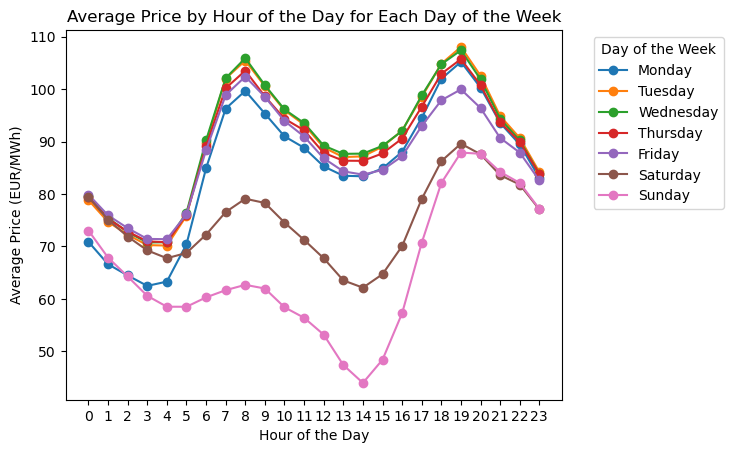

In [37]:
# Plotting hourly patterns for each day of the week separately
for day in day_order:
    weekly_data = grouped_by_day_hour[grouped_by_day_hour['Day_of_Week'] == day]
    plt.plot(weekly_data['Hour'], weekly_data['Day Ahead Auction (CH)'], marker='o', label=day)

plt.title('Average Price by Hour of the Day for Each Day of the Week')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Price (EUR/MWh)')
plt.xticks(range(0, 24))  
plt.legend(title='Day of the Week', bbox_to_anchor=(1.05, 1))
plt.show()

While prices tend to be lower during weekends, the observed patterns remain similar with two peaks of high and low prices.

### What are the average negative prices per year?

In [38]:
# Calculating the average negative price per year
average_negative_price = negative_price_data.groupby('Year')['Day Ahead Auction (CH)'].mean().reset_index(name='Average_Negative_Price')
print(average_negative_price)

   Year  Average_Negative_Price
0  2015               -6.776667
1  2016              -14.790417
2  2017              -34.190000
3  2018              -11.089310
4  2019              -13.881176
5  2020              -13.456267
6  2021              -19.899268
7  2022               -1.000000
8  2023              -18.701579
9  2024              -18.597500


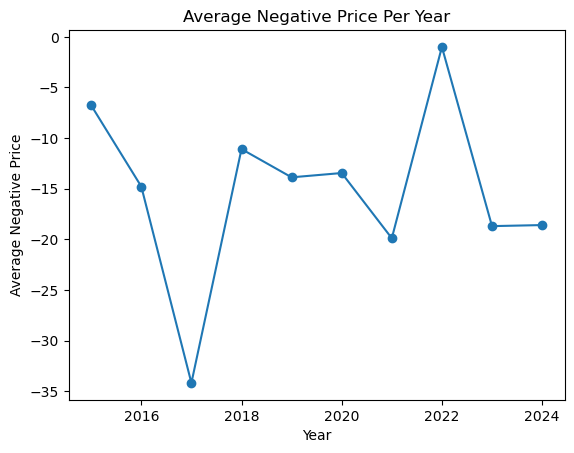

In [39]:
# Plotting the average negative price per year
plt.plot(average_negative_price['Year'], average_negative_price['Average_Negative_Price'], marker='o')
plt.title('Average Negative Price Per Year')
plt.xlabel('Year')
plt.ylabel('Average Negative Price')
plt.show()

In [40]:
# Calculating the overall average of 'Day Ahead Auction (CH)' excluding 2022 for further analysis
negative_price_data_without_2022 = negative_price_data[negative_price_data['Year'] != 2022]
overall_average_without_2022 = negative_price_data_without_2022['Day Ahead Auction (CH)'].mean()
average_without_2022_kwh = overall_average_without_2022 / 1000

### What are the yearly average prices for 19h (typically the highest price throughout the day)?

In [41]:
# Calculating the average price at 19:00 for each year
price_data['Hour'] = price_data['Date'].dt.hour
average_price_19h = price_data[price_data['Hour'] == 19].groupby('Year')['Day Ahead Auction (CH)'].mean().reset_index(name='Avg_Price_19h')
print(average_price_19h)

   Year  Avg_Price_19h
0  2015      48.823479
1  2016      45.680902
2  2017      54.682274
3  2018      61.289260
4  2019      48.168027
5  2020      42.760464
6  2021     136.772658
7  2022     336.295123
8  2023     133.034521
9  2024      98.350710


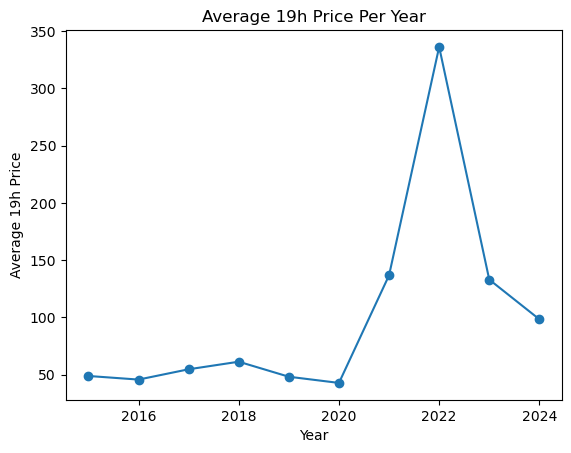

In [42]:
# Plotting the average negative price per year
plt.plot(average_price_19h['Year'], average_price_19h['Avg_Price_19h'], marker='o')
plt.title('Average 19h Price Per Year')
plt.xlabel('Year')
plt.ylabel('Average 19h Price')
plt.show()

From the plot, it is evident that prices in 2022 were significantly higher compared to other years. This helps explain why the number of negative price occurrences was notably low in 2022.

## Simulations
<a id="Simulation"></a>

### Calculating potential profit based on the 2023 and 2024 data
The following scenarios have been tested.
* Scenario 1: Buy at 0 or below and sell from 19h (typically the highest price)
* Scenario 2: Buy at two low peaks and sell at two high peaks
* Scenario 3: Buy at two low peaks and sell at two high peaks except for Sunday transactions that are to be sold on Monday
* Scenario 4: Buy at bottom 40% prices and sell at top 40% prices
* Scenario 5: Buy at bottom 25% prices and sell at top 25% prices
* Scenario 6: Buy at bottom 15% prices and sell at top 15% prices

In [43]:
# Setting up parameters 
storage_capacity = 500  # kWh
charge_rate = 250  # kWh, equivalent to 0.5C
discharge_rate = 500  # kWh, equivalent to 1C
usable_capacity_rate = 0.7 # As per our discussion
efficiency = 0.9

In [44]:
# Setting 'Date' as index for time series
price_data.set_index('Date', inplace=True)

# Converting prices from EUR/MWh to EUR/kWh
price_data['Price_kWh'] = price_data['Day Ahead Auction (CH)'] / 1000

# Extracting yearly data
price_data_2023 = price_data[price_data.index.year == 2023]
price_data_2024 = price_data[price_data.index.year == 2024]

#### Scenario 1: Buy at 0 or below and sell from 19h (typically the highest price)

In [45]:
def simulate_scenario_1(price_data, price_column, storage_capacity, charge_rate, discharge_rate, usable_capacity_rate, efficiency, time_interval='1h'):
    state_of_charge = 0  # kWh
    profit = 0  # EUR
    cost = 0  # EUR
    usable_capacity = storage_capacity * usable_capacity_rate

    # Adjust for 15-minute intervals
    if time_interval == '15min':
        charge_energy_per_interval = charge_rate / 4  # Divide by 4 for 15-minute intervals
        discharge_energy_per_interval = discharge_rate / 4
    else: 
        charge_energy_per_interval = charge_rate
        discharge_energy_per_interval = discharge_rate

    for timestamp, price in price_data[price_column].items():
        # Buy when price is 0 or below
        if price <= 0 and state_of_charge < usable_capacity:
            energy_to_buy = min(charge_energy_per_interval, usable_capacity - state_of_charge)
            cost += energy_to_buy * price  
            state_of_charge += energy_to_buy

        # Sell from 19h
        elif 19 <= timestamp.hour and state_of_charge > 0:
            energy_to_sell = min(discharge_energy_per_interval, state_of_charge)
            revenue = energy_to_sell * efficiency * price
            state_of_charge -= energy_to_sell
            profit += revenue

    return profit - cost

#### Scenario 2: Buy at two low peaks and sell at two high peaks 

In [46]:
def simulate_scenario_2(price_data, price_column, storage_capacity, charge_rate, discharge_rate, usable_capacity_rate, efficiency, time_interval='1h'):
    state_of_charge = 0  # kWh
    profit = 0  # EUR
    cost = 0  # EUR
    usable_capacity = storage_capacity * usable_capacity_rate
    
    # Adjust for 15-minute intervals
    if time_interval == '15min':
        charge_energy_per_interval = charge_rate / 4  # Divide by 4 for 15-minute intervals
        discharge_energy_per_interval = discharge_rate / 4
    else:  
        charge_energy_per_interval = charge_rate
        discharge_energy_per_interval = discharge_rate

    for timestamp, price in price_data[price_column].items():
        hour = timestamp.hour

        # Buy at 3-5 AM or 1-3 PM
        if (3 <= hour <= 5 or 13 <= hour <= 15) and state_of_charge < usable_capacity:
            energy_to_buy = min(charge_energy_per_interval, usable_capacity - state_of_charge)
            cost += energy_to_buy * price
            state_of_charge += energy_to_buy 

        # Sell at 8-9 AM or 19-20 PM
        elif (8 <= hour <= 9 or 19 <= hour <= 20) and state_of_charge > 0:
            energy_to_sell = min(discharge_energy_per_interval, state_of_charge)
            revenue = energy_to_sell * efficiency * price
            state_of_charge -= energy_to_sell
            profit += revenue

    return profit - cost

#### Scenario 3: Buy at two low peaks and sell at two high peaks except for Sunday transactions that are to sold on Monday

In [47]:
def simulate_scenario_3(price_data, price_column, storage_capacity, charge_rate, discharge_rate, usable_capacity_rate, efficiency, time_interval='1h'):
    state_of_charge = 0  # kWh
    profit = 0  # EUR
    cost = 0  # EUR
    usable_capacity = storage_capacity * usable_capacity_rate
    last_charge_day = None  # Tracking days
    
    # Adjust for time intervals
    if time_interval == '15min':
        charge_energy_per_interval = charge_rate / 4  # Divide by 4 for 15-minute intervals
        discharge_energy_per_interval = discharge_rate / 4
    else:  
        charge_energy_per_interval = charge_rate
        discharge_energy_per_interval = discharge_rate
    
    for timestamp, price in price_data[price_column].items():
        hour = timestamp.hour
        day_of_week = timestamp.weekday()  # 0 = Monday, 6 = Sunday
        
        # Sunday 
        if day_of_week == 6:
            if (3 <= hour <= 5 or 13 <= hour <= 15) and state_of_charge < usable_capacity:
                energy_to_buy = min(charge_energy_per_interval, usable_capacity - state_of_charge)
                cost += energy_to_buy * price
                state_of_charge += energy_to_buy 
                last_charge_day = 6  # Mark Sunday
            
            elif (8 <= hour <= 9) and state_of_charge > 0:
                energy_to_sell = min(discharge_energy_per_interval, state_of_charge)
                revenue = energy_to_sell * efficiency * price
                state_of_charge -= energy_to_sell
                profit += revenue
        
        # Monday
        elif day_of_week == 0:
            if last_charge_day == 6 and (7 <= hour <= 9) and state_of_charge > 0:
                energy_to_sell = min(discharge_energy_per_interval, state_of_charge)
                revenue = energy_to_sell * efficiency * price
                state_of_charge -= energy_to_sell
                profit += revenue
                last_charge_day = None  # Reset tracking
                
            elif (13 <= hour <= 15) and state_of_charge < usable_capacity:
                energy_to_buy = min(charge_energy_per_interval, usable_capacity - state_of_charge)
                cost += energy_to_buy * price
                state_of_charge += energy_to_buy 
                
            elif (19 <= hour <= 20) and state_of_charge > 0:
                energy_to_sell = min(discharge_energy_per_interval, state_of_charge)
                revenue = energy_to_sell * efficiency * price
                state_of_charge -= energy_to_sell
                profit += revenue
        
        # Tuesday to Saturday 
        elif day_of_week in [1, 2, 3, 4, 5]:
            if (3 <= hour <= 5 or 13 <= hour <= 15) and state_of_charge < usable_capacity:
                energy_to_buy = min(charge_energy_per_interval, usable_capacity - state_of_charge)
                cost += energy_to_buy * price
                state_of_charge += energy_to_buy 
                
            elif (8 <= hour <= 9 or 19 <= hour <= 20) and state_of_charge > 0:
                energy_to_sell = min(discharge_energy_per_interval, state_of_charge)
                revenue = energy_to_sell * efficiency * price
                state_of_charge -= energy_to_sell
                profit += revenue

    return profit - cost

#### Scenario 4: Buy at bottom 40% prices and sell at top 40% prices

In [48]:
def simulate_scenario_4(price_data, price_column, storage_capacity, charge_rate, discharge_rate, usable_capacity_rate, efficiency, time_interval='1h'):
    state_of_charge = 0  # kWh
    profit = 0  # EUR
    cost = 0  # EUR
    usable_capacity = storage_capacity * usable_capacity_rate
    last_charge_time = None

    # Adjust for 15-minute intervals 
    if time_interval == '15min':
        charge_energy_per_interval = charge_rate / 4  # Divide by 4 for 15-minute intervals
        discharge_energy_per_interval = discharge_rate / 4
    else:  
        charge_energy_per_interval = charge_rate
        discharge_energy_per_interval = discharge_rate 

    # 40% and 60% thresholds for prices
    low_price_threshold_s4 = price_data[price_column].quantile(0.4)
    high_price_threshold_s4 = price_data[price_column].quantile(0.6)

    for timestamp, price in price_data[price_column].items():
        if 19 <= timestamp.hour and state_of_charge > 0:
            energy_to_sell = min(discharge_energy_per_interval, state_of_charge)
            revenue = energy_to_sell * efficiency * price
            state_of_charge -= energy_to_sell
            profit += revenue
            
        # Buy when price is at or below the 40th percentile and storage is not full
        elif price <= low_price_threshold_s4 and state_of_charge < usable_capacity:
            energy_to_buy = min(charge_energy_per_interval, usable_capacity - state_of_charge)
            cost += energy_to_buy * price
            state_of_charge += energy_to_buy 
            
        # Sell when price is at or above the 60th percentile and storage is not empty
        elif price >= high_price_threshold_s4 and state_of_charge > 0:
            energy_to_sell = min(discharge_energy_per_interval, state_of_charge)
            revenue = energy_to_sell * efficiency * price
            state_of_charge -= energy_to_sell
            profit += revenue

    return profit - cost

#### Scenario 5: Buy at bottom 25% prices and sell at top 25% prices

In [49]:
def simulate_scenario_5(price_data, price_column, storage_capacity, charge_rate, discharge_rate, usable_capacity_rate, efficiency, time_interval='1h'):
    state_of_charge = 0  # kWh
    profit = 0  # EUR
    cost = 0  # EUR
    usable_capacity = storage_capacity * usable_capacity_rate
    last_charge_time = None

    # Adjust for 15-minute intervals 
    if time_interval == '15min':
        charge_energy_per_interval = charge_rate / 4  # Divide by 4 for 15-minute intervals
        discharge_energy_per_interval = discharge_rate / 4
    else:  
        charge_energy_per_interval = charge_rate
        discharge_energy_per_interval = discharge_rate

    # 25% and 75% thresholds for prices
    low_price_threshold_s5 = price_data[price_column].quantile(0.25)
    high_price_threshold_s5 = price_data[price_column].quantile(0.75)

    for timestamp, price in price_data[price_column].items():
        if 19 <= timestamp.hour and state_of_charge > 0:
            energy_to_sell = min(discharge_energy_per_interval, state_of_charge)
            revenue = energy_to_sell * efficiency * price
            state_of_charge -= energy_to_sell
            profit += revenue
            
        # Buy when price is at or below the 25th percentile and storage is not full
        elif price <= low_price_threshold_s5 and state_of_charge < usable_capacity:
            energy_to_buy = min(charge_energy_per_interval, usable_capacity - state_of_charge)
            cost += energy_to_buy * price
            state_of_charge += energy_to_buy 
            
        # Sell when price is at or above the 75th percentile and storage is not empty
        elif price >= high_price_threshold_s5 and state_of_charge > 0:
            energy_to_sell = min(discharge_energy_per_interval, state_of_charge)
            revenue = energy_to_sell * efficiency * price
            state_of_charge -= energy_to_sell
            profit += revenue

    return profit - cost

#### Scenario 6: Buy at bottom 15% prices and sell at top 15% prices

In [50]:
def simulate_scenario_6(price_data, price_column, storage_capacity, charge_rate, discharge_rate, usable_capacity_rate, efficiency, time_interval='1h'):
    state_of_charge = 0  # kWh
    profit = 0  # EUR
    cost = 0  # EUR
    usable_capacity = storage_capacity * usable_capacity_rate
    last_charge_time = None

    # Adjust for 15-minute intervals 
    if time_interval == '15min':
        charge_energy_per_interval = charge_rate / 4  # Divide by 4 for 15-minute intervals
        discharge_energy_per_interval = discharge_rate / 4
    else:  
        charge_energy_per_interval = charge_rate
        discharge_energy_per_interval = discharge_rate

    # 15% and 85% thresholds for prices
    low_price_threshold_s6 = price_data[price_column].quantile(0.15)
    high_price_threshold_s6 = price_data[price_column].quantile(0.85)

    for timestamp, price in price_data[price_column].items():
        if 19 <= timestamp.hour and state_of_charge > 0:
            energy_to_sell = min(discharge_energy_per_interval, state_of_charge)
            revenue = energy_to_sell * efficiency * price
            state_of_charge -= energy_to_sell
            profit += revenue
            
        # Buy when price is at or below the 15th percentile and storage is not full
        elif price <= low_price_threshold_s6 and state_of_charge < usable_capacity:
            energy_to_buy = min(charge_energy_per_interval, usable_capacity - state_of_charge)
            cost += energy_to_buy * price
            state_of_charge += energy_to_buy 
            
        # Sell when price is at or above the 85th percentile and storage is not empty
        elif price >= high_price_threshold_s6 and state_of_charge > 0:
            energy_to_sell = min(discharge_energy_per_interval, state_of_charge)
            revenue = energy_to_sell * efficiency * price
            state_of_charge -= energy_to_sell
            profit += revenue

    return profit - cost

### Results

In [51]:
# Simulating for 2023
profit_2023_s1 = simulate_scenario_1(price_data_2023, 'Price_kWh', storage_capacity, charge_rate, discharge_rate, usable_capacity_rate, efficiency, time_interval='1h')
profit_2023_s2 = simulate_scenario_2(price_data_2023, 'Price_kWh', storage_capacity, charge_rate, discharge_rate, usable_capacity_rate, efficiency, time_interval='1h')
profit_2023_s3 = simulate_scenario_3(price_data_2023, 'Price_kWh', storage_capacity, charge_rate, discharge_rate, usable_capacity_rate, efficiency, time_interval='1h')
profit_2023_s4 = simulate_scenario_4(price_data_2023, 'Price_kWh', storage_capacity, charge_rate, discharge_rate, usable_capacity_rate, efficiency, time_interval='1h')
profit_2023_s5 = simulate_scenario_5(price_data_2023, 'Price_kWh', storage_capacity, charge_rate, discharge_rate, usable_capacity_rate, efficiency, time_interval='1h')
profit_2023_s6 = simulate_scenario_6(price_data_2023, 'Price_kWh', storage_capacity, charge_rate, discharge_rate, usable_capacity_rate, efficiency, time_interval='1h')

# Simulating for 2024
profit_2024_s1 = simulate_scenario_1(price_data_2024, 'Price_kWh', storage_capacity, charge_rate, discharge_rate, usable_capacity_rate, efficiency, time_interval='1h')
profit_2024_s2 = simulate_scenario_2(price_data_2024, 'Price_kWh', storage_capacity, charge_rate, discharge_rate, usable_capacity_rate, efficiency, time_interval='1h')
profit_2024_s3 = simulate_scenario_3(price_data_2024, 'Price_kWh', storage_capacity, charge_rate, discharge_rate, usable_capacity_rate, efficiency, time_interval='1h')
profit_2024_s4 = simulate_scenario_4(price_data_2024, 'Price_kWh', storage_capacity, charge_rate, discharge_rate, usable_capacity_rate, efficiency, time_interval='1h')
profit_2024_s5 = simulate_scenario_5(price_data_2024, 'Price_kWh', storage_capacity, charge_rate, discharge_rate, usable_capacity_rate, efficiency, time_interval='1h')
profit_2024_s6 = simulate_scenario_6(price_data_2024, 'Price_kWh', storage_capacity, charge_rate, discharge_rate, usable_capacity_rate, efficiency, time_interval='1h')

print("Profit for 2023")
print(f"Scenario 1: {profit_2023_s1:.2f} EUR")
print(f"Scenario 2: {profit_2023_s2:.2f} EUR")
print(f"Scenario 3: {profit_2023_s3:.2f} EUR")
print(f"Scenario 4: {profit_2023_s4:.2f} EUR")
print(f"Scenario 5: {profit_2023_s5:.2f} EUR")
print(f"Scenario 6: {profit_2023_s6:.2f} EUR\n")
print("Profit for 2024")
print(f"Scenario 1: {profit_2024_s1:.2f} EUR")
print(f"Scenario 2: {profit_2024_s2:.2f} EUR")
print(f"Scenario 3: {profit_2024_s3:.2f} EUR")
print(f"Scenario 4: {profit_2024_s4:.2f} EUR")
print(f"Scenario 5: {profit_2024_s5:.2f} EUR")
print(f"Scenario 6: {profit_2024_s6:.2f} EUR")

Profit for 2023
Scenario 1: 449.08 EUR
Scenario 2: 6066.28 EUR
Scenario 3: 5612.44 EUR
Scenario 4: 1064.88 EUR
Scenario 5: 1512.41 EUR
Scenario 6: 1446.44 EUR

Profit for 2024
Scenario 1: 1414.80 EUR
Scenario 2: 5895.10 EUR
Scenario 3: 5702.01 EUR
Scenario 4: 899.00 EUR
Scenario 5: 1507.29 EUR
Scenario 6: 1958.61 EUR


There must be room for improvement, but with the initial cost of the battery (200-300k EUR) and its lifespan of 15 years, the annual profit from energy trading seems insufficient to cover the costs in the short term. 

## Groupe E Tariff Simulations
<a id="Groupe-E"></a>
Groupe E is one of the pioneer suppliers offering dynamic pricing in Switzerland. To estimate the potential profit for captive customers in the region, the same simulation models have been applied to their historical pricing data.

Source: https://www.groupe-e.ch/fr/energie/electricite/clients-prives/vario

In [52]:
vario_data = pd.read_csv("tariff_data_2021_to_2024.csv")

missing_vario = vario_data.isnull().sum()
print(missing_vario)

start_timestamp    0
end_timestamp      0
vario_plus         0
vario_grid         0
dt_plus            0
dtype: int64


In [53]:
vario_data['start_timestamp'] = pd.to_datetime(vario_data['start_timestamp'], format='%d.%m.%Y %H:%M')
vario_data['Year'] = vario_data['start_timestamp'].dt.year

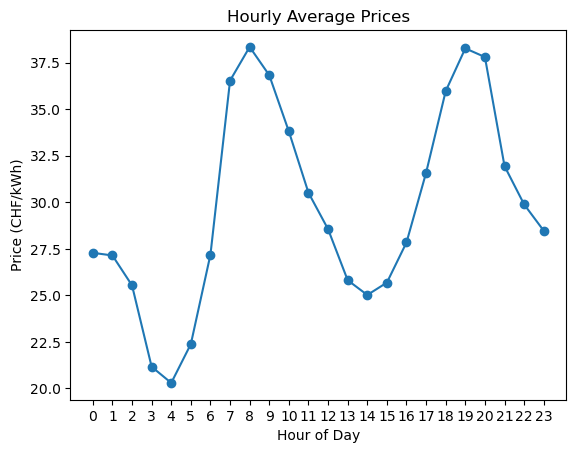

In [54]:
# Extracting the hour 
vario_data['hour'] = vario_data['start_timestamp'].dt.hour

# Grouping by the hour and calculating the average price
hourly_trend = vario_data.groupby('hour')['vario_plus'].mean()

plt.plot(hourly_trend.index, hourly_trend, marker='o')
plt.title("Hourly Average Prices")
plt.xlabel("Hour of Day")
plt.ylabel("Price (CHF/kWh)")
plt.xticks(range(0, 24))
plt.show()

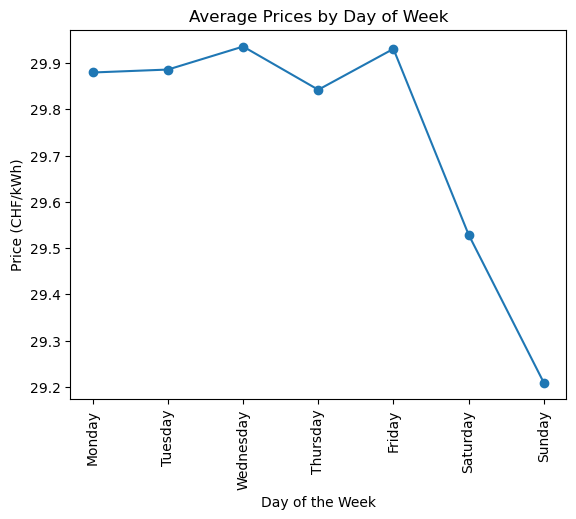

In [55]:
# Extracting the day of the week (0 = Monday, 6 = Sunday)
vario_data['day_of_week'] = vario_data['start_timestamp'].dt.dayofweek

# Grouping by day of the week and calculating the average price
weekly_trend = vario_data.groupby('day_of_week')['vario_plus'].mean()

# For readability
days_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
weekly_trend.index = weekly_trend.index.map(days_map)

plt.plot(weekly_trend.index, weekly_trend, marker='o')
plt.title("Average Prices by Day of Week")
plt.xlabel("Day of the Week")
plt.ylabel("Price (CHF/kWh)")
plt.xticks(rotation=90)
plt.show()

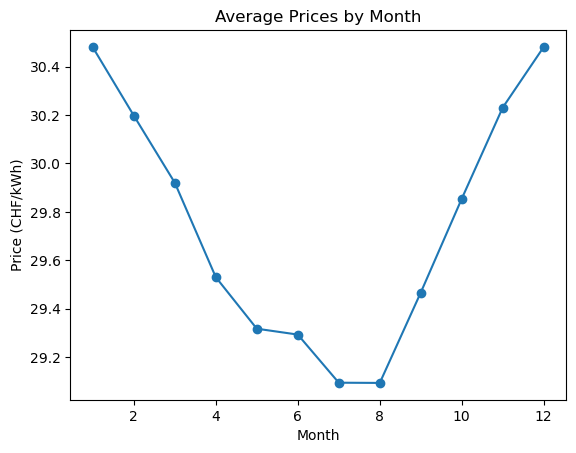

In [56]:
# Extracting the month
vario_data['month'] = vario_data['start_timestamp'].dt.month

# Grouping by month and calculating the average price
yearly_trend = vario_data.groupby('month')['vario_plus'].mean()

plt.plot(yearly_trend.index, yearly_trend, marker='o')
plt.title("Average Prices by Month")
plt.xlabel("Month")
plt.ylabel("Price (CHF/kWh)")
plt.show()

In [57]:
# 11.45 ct/kWh pour l’énergie grise as per Groupe E
tariff_2024 = 14.45
vario_data['feedin_tariff'] = tariff_2024

vario_data_2024 = vario_data[vario_data['Year']== 2024]

In [58]:
# Setting up parameters 
storage_capacity = 500  # kWh
charge_rate = 250  # kWh, equivalent to 0.5C
discharge_rate = 500  # kWh, equivalent to 1C
usable_capacity_rate = 0.7 # As per our discussion
efficiency = 0.9

In [59]:
state_of_charge = 0  # kWh
profit = 0  # CHF
cost = 0  # CHF
usable_capacity = storage_capacity * usable_capacity_rate

charge_energy_per_interval = charge_rate / 4  # Adjusting for 15-minute intervals
discharge_energy_per_interval = discharge_rate / 4

total_energy_bought = 0
total_energy_sold = 0

for index, row in vario_data_2024.iterrows():
    timestamp = row['start_timestamp']   

    # Buy at < fixed tariff
    if row['vario_plus'] * 0.63 < tariff_2024 and state_of_charge < usable_capacity:
        energy_to_buy = min(charge_energy_per_interval, usable_capacity - state_of_charge)
        cost += energy_to_buy * row['vario_plus'] * 0.63  # Network fee refund 37%
        state_of_charge += energy_to_buy

        total_energy_bought += energy_to_buy # Tracking energy bought and price

    # Sell when there are energy
    elif state_of_charge > 0:
        energy_to_sell = min(discharge_energy_per_interval, state_of_charge)
        profit += energy_to_sell * 0.9 * row['feedin_tariff']  
        state_of_charge -= energy_to_sell

        total_energy_sold += energy_to_sell  # Tracking energy sold and price

total = profit - cost
print(f"\nTotal energy bought: {total_energy_bought:.2f} kWh")
print(f"Total energy sold: {total_energy_sold:.2f} kWh")
print(f"Total profit: {profit / 100:.2f} CHF") # Converting centimes to CHF
print(f"Total cost: {cost / 100:.2f} CHF")
print(f"Total: {total / 100:.2f} CHF")


Total energy bought: 372787.50 kWh
Total energy sold: 372787.50 kWh
Total profit: 48481.01 CHF
Total cost: 44986.65 CHF
Total: 3494.37 CHF


In [60]:
balance_2023 = pd.read_excel("2023_balance.xlsx") #ct/kWh
balance_2024 = pd.read_excel("2024_balance.xlsx")

missing_balance_2023 = balance_2023.isnull().sum()
print(missing_balance_2023)
missing_balance_2024 = balance_2024.isnull().sum()
print(missing_balance_2024)

date        0
BG-long     0
BG-short    0
dtype: int64
date        0
BG-long     0
BG-short    0
dtype: int64


In [61]:
balance_2023['date'] = pd.to_datetime(balance_2023['date'], format='%d.%m.%Y %H:%M:%S')
balance_2024['date'] = pd.to_datetime(balance_2024['date'], format='%d.%m.%Y %H:%M:%S')

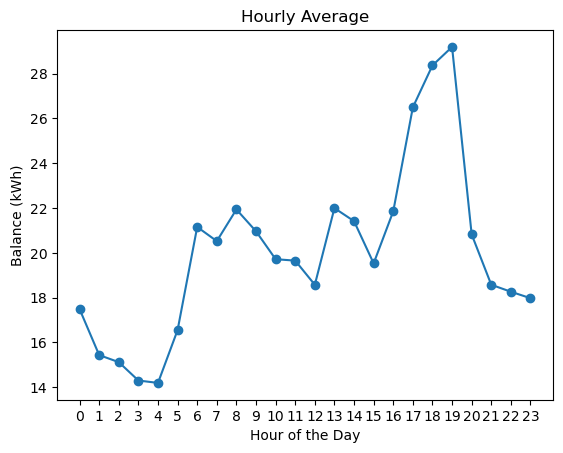

In [62]:
# Extracting the hour
balance_2024['hour'] = balance_2024['date'].dt.hour

# Grouping by hour and calculating the average BG-short
daily_hourly_trend = balance_2024.groupby('hour')[['BG-short']].mean()

plt.plot(daily_hourly_trend.index, daily_hourly_trend['BG-short'], marker='o', label='BG-short')
plt.title("Hourly Average")
plt.xlabel("Hour of the Day")
plt.ylabel("Balance (kWh)")
plt.xticks(range(24))  
plt.show()

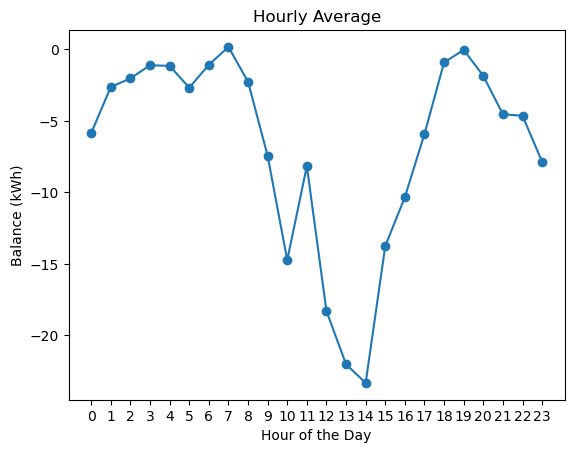

In [63]:
# Extracting the hour
balance_2024['hour'] = balance_2024['date'].dt.hour

# Grouping by hour and calculating the average BG-long
daily_hourly_trend = balance_2024.groupby('hour')[['BG-long']].mean()

plt.plot(daily_hourly_trend.index, daily_hourly_trend['BG-long'], marker='o', label='BG-long')
plt.title("Hourly Average")
plt.xlabel("Hour of the Day")
plt.ylabel("Balance (kWh)")
plt.xticks(range(24))  
plt.show()

In [64]:
merged_price_2024 = vario_data_2024.merge(
    balance_2024,
    left_on='start_timestamp',  
    right_on='date',           
    how='inner'                
)

In [65]:
# Setting up parameters 
storage_capacity = 500  # kWh
charge_rate = 250  # kWh, equivalent to 0.5C
discharge_rate = 500  # kWh, equivalent to 1C
usable_capacity_rate = 0.7 # As per our discussion
efficiency = 0.9

In [66]:
state_of_charge = 0  # kWh
profit = 0  # CHF
cost = 0  # CHF
usable_capacity = storage_capacity * usable_capacity_rate

charge_energy_per_interval = charge_rate / 4  # Adjusting for 15-minute intervals
discharge_energy_per_interval = discharge_rate / 4

total_energy_bought = 0
total_energy_sold = 0

for index, row in merged_price_2024.iterrows():
    timestamp = row['start_timestamp']  
    hour = timestamp.hour  

    # Buy at 3-5 AM
    if 3 <= hour <= 5 and state_of_charge < usable_capacity:
        energy_to_buy = min(charge_energy_per_interval, usable_capacity - state_of_charge)
        cost += energy_to_buy * row['vario_plus'] * 0.63  # Network fee refund 37%
        state_of_charge += energy_to_buy

        total_energy_bought += energy_to_buy # Tracking energy bought and price

    # Sell at 19-20 PM
    elif 19 <= hour <= 20 and state_of_charge > 0:
        energy_to_sell = min(discharge_energy_per_interval, state_of_charge)
        profit += energy_to_sell * 0.9 * row['BG-short']  
        state_of_charge -= energy_to_sell

        total_energy_sold += energy_to_sell  # Tracking energy sold and price

total = profit - cost
print(f"\nTotal energy bought: {total_energy_bought:.2f} kWh")
print(f"Total energy sold: {total_energy_sold:.2f} kWh")
print(f"Total profit: {profit / 100:.2f} CHF") # Converting centimes to CHF
print(f"Total cost: {cost / 100:.2f} CHF")
print(f"Total: {total / 100:.2f} CHF")


Total energy bought: 128100.00 kWh
Total energy sold: 128100.00 kWh
Total profit: 33689.97 CHF
Total cost: 17604.07 CHF
Total: 16085.91 CHF


The results indicate that with a fixed discharge tariff from Groupe E, it is challenging to fully capitalize on their dynamic consumption tariff. In Scenario 1, profitability remains unattainable in both years due to the absence of negative prices. However, introducing a dynamic feed-in tariff, such as the balance prices offered by Swissgrid in this example, would yield more interesting results.

## Predictions
<a id="Prediction"></a>

#### Annual PV production including predictions from the official statistics

Source: https://www.swissolar.ch/02_markt-politik/solarmonitor-schweiz/solarmonitor_schweiz_2024_fr.pdf

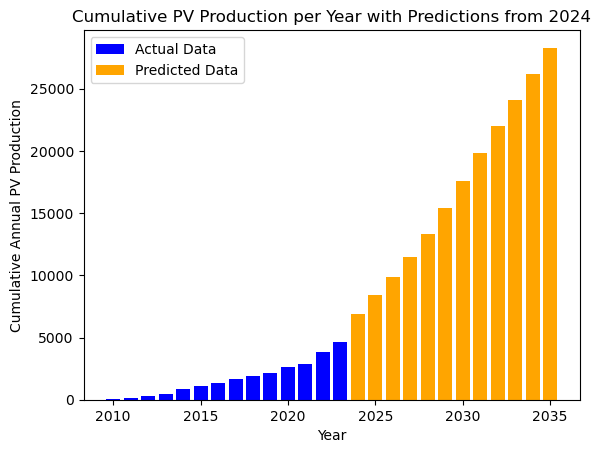

In [67]:
# Plotting annual PV production with predictions from 2024
colors = ['blue' if year < 2024 else 'orange' for year in production_data['Year']]

plt.bar(production_data['Year'], production_data['PV Production (GWh)'], color=colors)
plt.title('Cumulative PV Production per Year with Predictions from 2024')
plt.xlabel('Year')
plt.ylabel('Cumulative Annual PV Production')
blue_patch = plt.Rectangle((0, 0), 1, 1, fc="blue", edgecolor='none')
orange_patch = plt.Rectangle((0, 0), 1, 1, fc="orange", edgecolor='none')
plt.legend([blue_patch, orange_patch], ['Actual Data', 'Predicted Data'])
plt.show()

In [68]:
# Displaying the official predictions from 2024 onwards
production_data.sort_values(by="Year", ascending=True)
production_data_2024_onwards = production_data[production_data["Year"] >= 2024]
print(production_data_2024_onwards)

    Year  PV Production (GWh)  Annual Production Growth
0   2035                28300                  1.080153
1   2034                26200                  1.087137
2   2033                24100                  1.095455
3   2032                22000                  1.111111
4   2031                19800                  1.125000
5   2030                17600                  1.142857
6   2029                15400                  1.157895
7   2028                13300                  1.156522
8   2027                11500                  1.161616
9   2026                 9900                  1.178571
10  2025                 8400                  1.217391
11  2024                 6900                  1.492215


#### Applying a ML model to PV production data (log transformation and linear regression)
To compare the results, the log transformation and the linear regression model has been applied to the PV production data up to the year 2023.

In [69]:
# Filtering data up to 2023
production_to_2023 = production_data[production_data['Year'] <= 2023].copy()

# Applying log transformation to PV Production
production_to_2023['Log_PV_Production'] = np.log(production_to_2023['PV Production (GWh)'])

X = production_to_2023['Year'].values.reshape(-1, 1) 
y = production_to_2023['Log_PV_Production'].values  

pv_model = LinearRegression()
pv_model.fit(X, y)

years = list(range(2024, 2036))
predicted_log_pv_production = []

for year in years:
    predicted_log_value = pv_model.predict([[year]])
    predicted_pv_production_value = np.exp(predicted_log_value[0])  
    predicted_log_pv_production.append(predicted_pv_production_value)
    print(f"{year}: {predicted_pv_production_value:.2f} GWh")

2024: 8248.00 GWh
2025: 10821.60 GWh
2026: 14198.22 GWh
2027: 18628.43 GWh
2028: 24440.99 GWh
2029: 32067.22 GWh
2030: 42073.03 GWh
2031: 55200.92 GWh
2032: 72425.05 GWh
2033: 95023.56 GWh
2034: 124673.39 GWh
2035: 163574.75 GWh


After applying the log transformation, the predicted values turned out to be greater than the official statistics. Given that the official statistics already appear optimistic, we will proceed with these official figures for further analyses.

#### Applying a ML model to negative price data based on production predictions (simple linear regression)

In [70]:
# Extracting the production data up to 2024
production_to_2024 = production_data[production_data['Year'] <= 2024]

production_negative = pd.merge(production_to_2024, negative_price_days, on='Year', how='inner')
# Excluding the data for 2022
production_negative = production_negative[production_negative['Year'] != 2022]

X = production_negative['PV Production (GWh)'].values.reshape(-1, 1)
y = production_negative['Negative_Price_Days'].values

price_model = LinearRegression()
price_model.fit(X, y)

years = list(range(2025, 2036))
predicted_negative_days = []

for year in years:
    pv_production = production_data.loc[production_data['Year'] == year, 'PV Production (GWh)'].values[0]
    predicted_negative_days_value = price_model.predict([[pv_production]])
    predicted_negative_days.append(predicted_negative_days_value[0])
    print(f"{year}: {predicted_negative_days_value[0]:.2f}")

2025: 65.47
2026: 79.47
2027: 94.40
2028: 111.20
2029: 130.80
2030: 151.33
2031: 171.87
2032: 192.40
2033: 212.00
2034: 231.60
2035: 251.20


In [71]:
r2score = price_model.score(X, y)
print(r2score)

0.8809774496060093


#### Applying a ML model to negative price data based on production predictions (log transformation and linear regression)

In [72]:
# Applying log transformation to the data
X_log = np.log(production_negative['PV Production (GWh)'].values).reshape(-1, 1)
y_log = np.log(production_negative['Negative_Price_Days'].values)

price_model_log = LinearRegression()
price_model_log.fit(X_log, y_log)

years = list(range(2025, 2036))
predicted_negative_days = []

for year in years:
    pv_production = production_data.loc[production_data['Year'] == year, 'PV Production (GWh)'].values[0]
    log_pv_production = np.log(pv_production)
    predicted_log_negative_days = price_model_log.predict([[log_pv_production]])
    predicted_negative_days_value = np.exp(predicted_log_negative_days[0])
    
    predicted_negative_days.append(predicted_negative_days_value)
    print(f"{year}: {predicted_negative_days_value:.2f}")

2025: 68.98
2026: 93.33
2027: 122.97
2028: 160.71
2029: 210.50
2030: 269.15
2031: 334.32
2032: 405.87
2033: 480.03
2034: 559.83
2035: 645.20


In [73]:
r2score_log = price_model_log.score(X_log, y_log)
print(r2score_log)

0.7648810596540165


#### Simulating the potential profit based on 2024 data

In [74]:
# For reproductibility
np.random.seed(0)

# Current number of negative price days in 2024
negative_price_days_2024 = negative_price_days.loc[negative_price_days['Year'] == 2024, 'Negative_Price_Days'].values[0]

# Calculating the extra negative price days based on 2024 data
for year in range(2025, 2031):
    predicted_negative_days_year = predicted_negative_days[year - 2025] 
    extra_negative_price_days_year = int(predicted_negative_days_year - negative_price_days_2024)

    if extra_negative_price_days_year > 0:
        price_data_year = price_data_2024.copy()  
        price_data_year['Date_only'] = price_data_year.index.date  # only date

        # Extracting non-negative price days
        non_negative_days = price_data_year[price_data_year['Price_kWh'] >= 0]['Date_only'].unique()

        # Checking if there are enough non-negative days
        if len(non_negative_days) >= extra_negative_price_days_year:
            # Randomly selecting the extra days
            selected_days = np.random.choice(non_negative_days, size=extra_negative_price_days_year, replace=False)
            
            for day in selected_days:
                # Selecting random hours 
                day_indices = price_data_year[price_data_year['Date_only'] == day].index
                selected_hour = np.random.choice(day_indices)

                # Applying the negative price 
                price_data_year.loc[selected_hour, 'Price_kWh'] = average_without_2022_kwh

            print(f"Adjusted price for {extra_negative_price_days_year} days")
        else:
            print(f"Not enough non-negative days for {year}.")

    # Simulating
    profit_year_s1 = simulate_scenario_1(price_data_year, 'Price_kWh', storage_capacity, charge_rate, discharge_rate, usable_capacity_rate, efficiency, time_interval='1h')
    profit_year_s2 = simulate_scenario_2(price_data_year, 'Price_kWh', storage_capacity, charge_rate, discharge_rate, usable_capacity_rate, efficiency, time_interval='1h')
    profit_year_s3 = simulate_scenario_3(price_data_year, 'Price_kWh', storage_capacity, charge_rate, discharge_rate, usable_capacity_rate, efficiency, time_interval='1h')
    profit_year_s4 = simulate_scenario_4(price_data_year, 'Price_kWh', storage_capacity, charge_rate, discharge_rate, usable_capacity_rate, efficiency, time_interval='1h')
    profit_year_s5 = simulate_scenario_5(price_data_year, 'Price_kWh', storage_capacity, charge_rate, discharge_rate, usable_capacity_rate, efficiency, time_interval='1h')
    profit_year_s6 = simulate_scenario_6(price_data_year, 'Price_kWh', storage_capacity, charge_rate, discharge_rate, usable_capacity_rate, efficiency, time_interval='1h')

    print(f"Profit for {year}")
    print(f"Scenario 1: {profit_year_s1:.2f} EUR")
    print(f"Scenario 2: {profit_year_s2:.2f} EUR")
    print(f"Scenario 3: {profit_year_s3:.2f} EUR")
    print(f"Scenario 4: {profit_year_s4:.2f} EUR")
    print(f"Scenario 5: {profit_year_s5:.2f} EUR")
    print(f"Scenario 6: {profit_year_s6:.2f} EUR\n")

Adjusted price for 8 days
Profit for 2025
Scenario 1: 1662.54 EUR
Scenario 2: 5914.62 EUR
Scenario 3: 5721.54 EUR
Scenario 4: 1047.46 EUR
Scenario 5: 1723.73 EUR
Scenario 6: 2177.66 EUR

Adjusted price for 33 days
Profit for 2026
Scenario 1: 2257.40 EUR
Scenario 2: 5846.61 EUR
Scenario 3: 5636.50 EUR
Scenario 4: 1404.35 EUR
Scenario 5: 2173.06 EUR
Scenario 6: 2606.78 EUR

Adjusted price for 62 days
Profit for 2027
Scenario 1: 2894.75 EUR
Scenario 2: 5946.48 EUR
Scenario 3: 5733.85 EUR
Scenario 4: 1850.38 EUR
Scenario 5: 2655.10 EUR
Scenario 6: 3189.27 EUR

Adjusted price for 100 days
Profit for 2028
Scenario 1: 3963.83 EUR
Scenario 2: 5834.98 EUR
Scenario 3: 5848.28 EUR
Scenario 4: 2792.49 EUR
Scenario 5: 3562.94 EUR
Scenario 6: 4229.67 EUR

Adjusted price for 150 days
Profit for 2029
Scenario 1: 4877.64 EUR
Scenario 2: 5895.94 EUR
Scenario 3: 5600.43 EUR
Scenario 4: 2894.73 EUR
Scenario 5: 3991.64 EUR
Scenario 6: 4727.72 EUR

Adjusted price for 209 days
Profit for 2030
Scenario 1: 610

## OFEN Data Analysis
<a id="OFEN"></a>
The Office fédéral de l'énergie (OFEN) database contains information on electricity production plants registered in the Swiss proof of origin systems. This includes plants with an output exceeding 30 kilovolt-amperes (kVA) as well as smaller plants (greater than 2 kilowatts) that have voluntarily registered. While the dataset is incomplete, it provides a more detailed and up-to-date view of current trends. For these reasons, we will also explore this dataset.

Source: https://opendata.swiss/fr/dataset/elektrizitatsproduktionsanlagen

In [75]:
ofen_pv_data = pd.read_csv("ElectricityProductionPlant.csv")

# Extracting photovoltaic data (subcat_2)
ofen_solar = ofen_pv_data[ofen_pv_data['SubCategory'] == 'subcat_2'].copy()

In [76]:
# Converting BeginningOfOperation to datetime 
ofen_solar['BeginningOfOperation'] = pd.to_datetime(ofen_solar['BeginningOfOperation'])

# Extracting month
ofen_solar['Month'] = ofen_solar['BeginningOfOperation'].dt.to_period('M')

# Grouping by month
ofen_by_month = ofen_solar.groupby('Month').agg({
    'xtf_id': 'count',        
    'InitialPower': 'sum',     
    'TotalPower': 'sum'        
}).reset_index()

# Calculating cumulative total power
ofen_by_month['CumulativeTotalPower'] = ofen_by_month['TotalPower'].cumsum()

print(ofen_by_month)

       Month  xtf_id  InitialPower  TotalPower  CumulativeTotalPower
0    1988-07       1          3.00        3.00                  3.00
1    1988-09       1          1.00        1.00                  4.00
2    1989-01       2         31.14       31.14                 35.14
3    1989-07       1         23.80       23.80                 58.94
4    1989-10       1          1.91        4.63                 63.57
..       ...     ...           ...         ...                   ...
403  2024-07    3348      84717.71    84721.91            6340611.65
404  2024-08    1963      46499.19    46499.19            6387110.84
405  2024-09    1421      36654.94    36654.94            6423765.78
406  2024-10     674      22818.48    22818.48            6446584.26
407  2024-11      83       4629.95     4629.95            6451214.21

[408 rows x 5 columns]


In [77]:
# Extracting Year 
ofen_by_month['Year'] = ofen_by_month['Month'].dt.year

# Grouping by Year
ofen_by_year = ofen_by_month.groupby('Year').agg({
    'TotalPower': 'sum',                  
    'CumulativeTotalPower': 'last'       
}).reset_index()

ofen_by_year.tail(15)

,Year,TotalPower,CumulativeTotalPower
22,2010,43416.47,122204.02
23,2011,126903.38,249107.40
24,2012,251772.61,500880.01
25,2013,302276.44,803156.45
26,2014,186519.39,989675.84
27,2015,410598.92,1400274.76
28,2016,262405.23,1662679.99
29,2017,224428.69,1887108.68
30,2018,232967.44,2120076.12
31,2019,288161.93,2408238.05


Based on monthly data, we will predict the cumulative total power for the years 2025 to 2030. To better capture patterns, only data from 2012 onwards will be used.

In [78]:
# Filtering to include only records from 2012 onwards
ofen_from_2012 = ofen_by_month[ofen_by_month['Month'].dt.year >= 2012].copy()

In [79]:
# Applying log transformation 
ofen_from_2012.loc[:, 'LogCumulativeTotalPower'] = np.log(ofen_from_2012['CumulativeTotalPower'])

# Extracting Year and Month from the 'Month'
ofen_from_2012.loc[:, 'Year'] = ofen_from_2012['Month'].dt.year
ofen_from_2012.loc[:, 'MonthNum'] = ofen_from_2012['Month'].dt.month

X = ofen_from_2012[['Year', 'MonthNum']]
y = ofen_from_2012['LogCumulativeTotalPower']  

model = LinearRegression()
model.fit(X, y)

years_future = np.arange(2025, 2031)  # Future years
months_future = np.arange(1, 13)  # Months (1 to 12)

# Creating a DataFrame 
future_data = pd.DataFrame([(year, month) for year in years_future for month in months_future], columns=['Year', 'MonthNum'])

# Predicting
future_log_predictions = model.predict(future_data)

# Converting log predictions back
future_predictions = np.exp(future_log_predictions)

future_data['CumulativeTotalPower'] = future_predictions
print(future_data)

    Year  MonthNum  CumulativeTotalPower
0   2025         1          7.009257e+06
1   2025         2          7.161781e+06
2   2025         3          7.317623e+06
3   2025         4          7.476857e+06
4   2025         5          7.639556e+06
..   ...       ...                   ...
67  2030         8          2.322391e+07
68  2030         9          2.372927e+07
69  2030        10          2.424562e+07
70  2030        11          2.477322e+07
71  2030        12          2.531229e+07

[72 rows x 3 columns]


In [80]:
# Formatting
pd.options.display.float_format = '{:,.2f}'.format
future_data.head(15)

,Year,MonthNum,CumulativeTotalPower
0,2025,1,"7,009,256.98"
1,2025,2,"7,161,780.69"
2,2025,3,"7,317,623.36"
3,2025,4,"7,476,857.23"
4,2025,5,"7,639,556.07"
5,2025,6,"7,805,795.29"
6,2025,7,"7,975,651.93"
7,2025,8,"8,149,204.71"
8,2025,9,"8,326,534.06"
9,2025,10,"8,507,722.14"


In [81]:
# Creating a column by combining 'Year' and 'MonthNum' 
future_data.loc[:, 'Date'] = pd.to_datetime(future_data[['Year', 'MonthNum']].astype(str).agg('-'.join, axis=1) + '-01')
print(future_data.head())

   Year  MonthNum  CumulativeTotalPower       Date
0  2025         1          7,009,256.98 2025-01-01
1  2025         2          7,161,780.69 2025-02-01
2  2025         3          7,317,623.36 2025-03-01
3  2025         4          7,476,857.23 2025-04-01
4  2025         5          7,639,556.07 2025-05-01


In [82]:
# Filtering to show only December numbers
yearly_data = future_data[future_data['MonthNum'] == 12]
print(yearly_data)

    Year  MonthNum  CumulativeTotalPower       Date
11  2025        12          8,882,012.25 2025-12-01
23  2026        12         10,951,544.70 2026-12-01
35  2027        12         13,503,283.72 2027-12-01
47  2028        12         16,649,584.70 2028-12-01
59  2029        12         20,528,982.18 2029-12-01
71  2030        12         25,312,289.57 2030-12-01


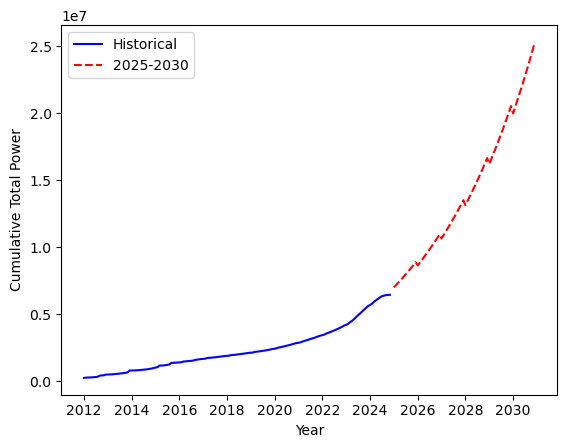

In [83]:
# Convert 'Month' to datatype
ofen_from_2012['Date'] = ofen_from_2012['Month'].dt.to_timestamp()

plt.plot(ofen_from_2012['Date'], ofen_from_2012['CumulativeTotalPower'], label='Historical', color='blue')
plt.plot(future_data['Date'], future_data['CumulativeTotalPower'], label='2025-2030', color='red', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Cumulative Total Power')
plt.legend()
plt.show()

While the numbers does not seem to align with official statistics, most likely due to its imcomplete nature, the results also show the exponential trend of PV installations.

## Conclusion
<a id="Conclusion"></a>

This report has analyzed trends, patterns and relationships of PV installations and electricity prices in Switzerland and assessed the potential profitability of energy storage systems using machine learning approaches. 

#### Key takeaways:

* Trends: There is a strong positive correlation between the number of PV installations and negative electricity prices. Negative price occurrences are more frequent over weekends and Mondays, and they typically happen around 2 pm. Finally, electricity prices generally follow a two-peak pattern throughout the day, with lower prices around 4 am and 2 pm, and higher prices around 8 am and 7 pm. 
* Profitability of Energy Storage: The report has simulated various scenarios for using an energy storage system to exploit price fluctuations. While some scenarios show potential profit, the initial cost of the battery might outweigh the short-term gains from energy trading on the spot market. 
* Need for Further Analysis: The report acknowledges that there is room for improvement in the analysis. Factors like the initial battery cost, lifespan and network fees need to be considered for a more comprehensive assessment.